專案根目錄已在系統路徑中: /Users/billy/HRR_project

--- 開始診斷目標: ECS ---

診斷摘要: 
  - 最佳模型: ridge
  - R² 分數: 0.0000
成功重現測試集，共 20 筆。

正在生成 Predicted vs. Actual Plot...


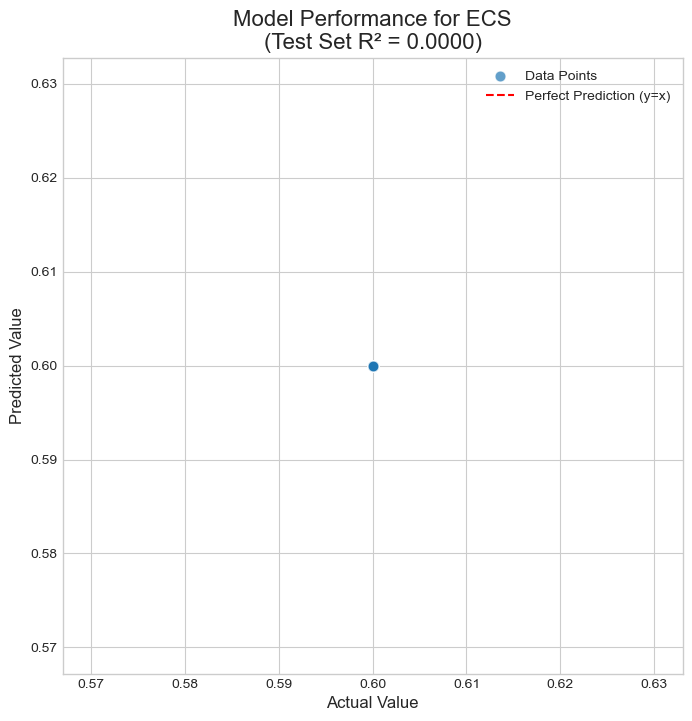


正在生成 RIDGE Coefficient Magnitude Plot...


/var/folders/sd/5klv01t979bckfxz9ytfvg440000gn/T/ipykernel_53099/2393206707.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(10, 8)); sns.barplot(x=coefs.values, y=coefs.index, palette='coolwarm')


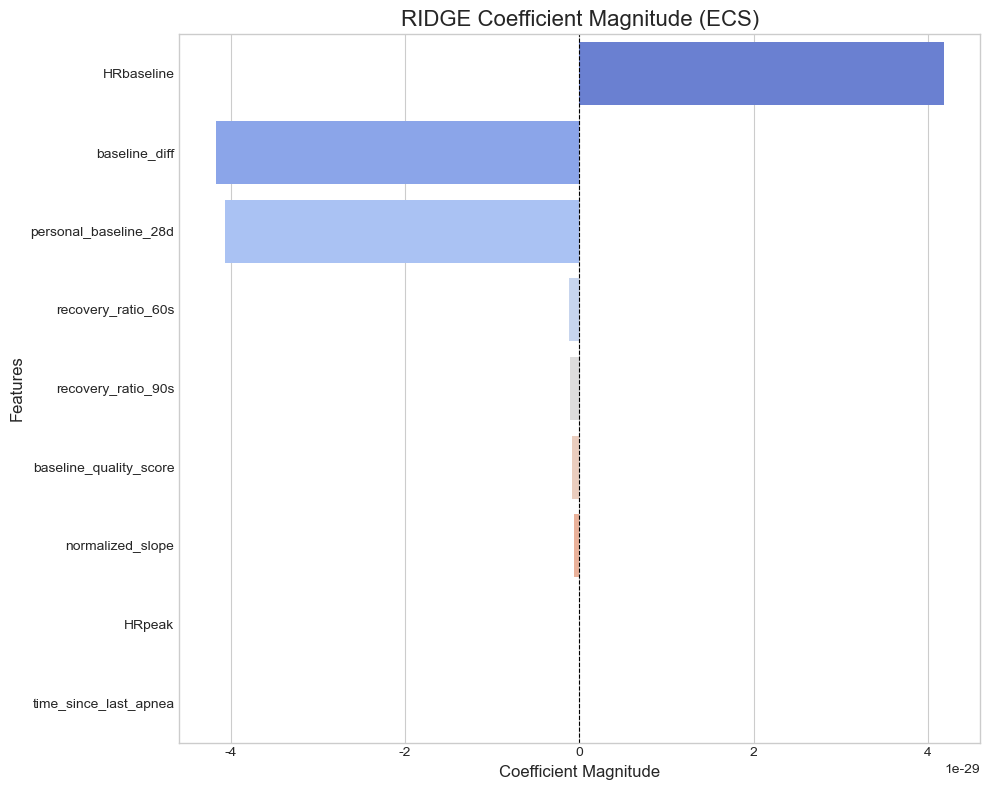


正在生成 Calibration Curve...


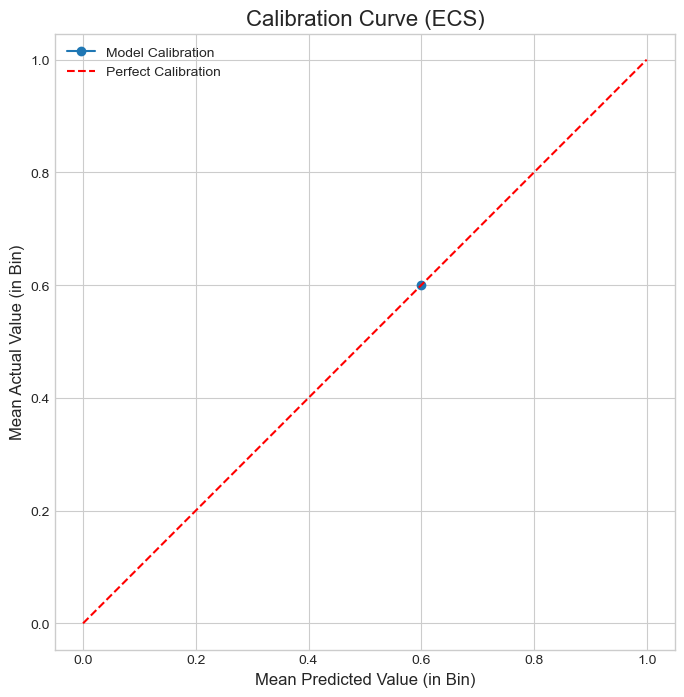


正在生成 Bland-Altman Plot...


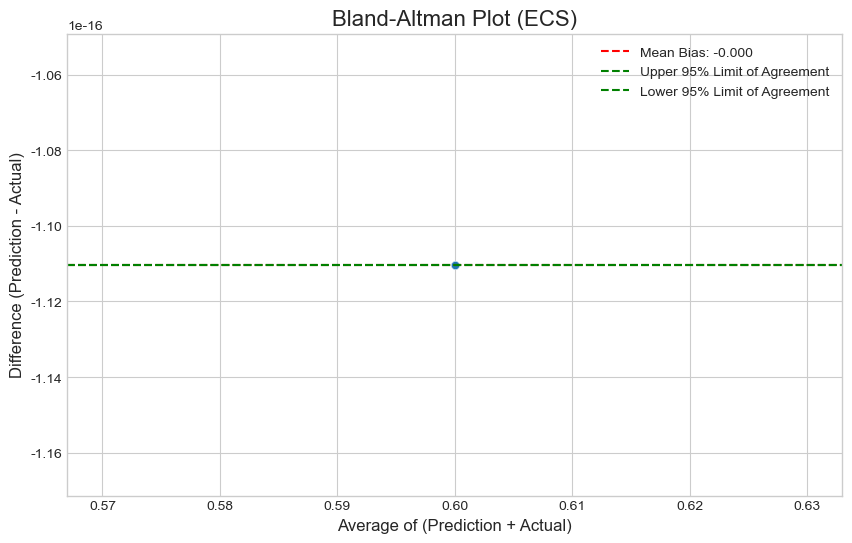


--- 診斷結束 ---


In [3]:
# ===================================================================
# 專案路徑設定
# ===================================================================
import sys
from pathlib import Path
notebook_dir = Path.cwd() 
project_root = notebook_dir.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
    print(f"專案根目錄已成功加入系統路徑: {project_root}")
else:
    print(f"專案根目錄已在系統路徑中: {project_root}")

# ===================================================================
# 導入所有必要的函式庫
# ===================================================================
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from paths import DIR_MODELS, DIR_FEATURES

# ===================================================================
# 圖表與環境設定
# ===================================================================
# # 因為圖表改為全英文，不再需要特別設定中文字體
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Heiti TC', 'PingFang TC', 'sans-serif']
# plt.rcParams['axes.unicode_minus'] = False 
plt.style.use('seaborn-v0_8-whitegrid')
TARGET_TO_INSPECT = 'ECS'
print(f"\n--- 開始診斷目標: {TARGET_TO_INSPECT} ---")

# ===================================================================
# 步驟一與二：載入產出物並重現測試集
# ===================================================================
model_dir = DIR_MODELS / TARGET_TO_INSPECT
best_model_path = model_dir / "best_model.joblib"
dataset_card_path = model_dir / "dataset_card.json"
feature_schema_path = model_dir / "feature_schema.json"
model = joblib.load(best_model_path)
with open(dataset_card_path, 'r', encoding='utf-8') as f: dataset_card = json.load(f)
with open(feature_schema_path, 'r', encoding='utf-8') as f: feature_schema = json.load(f)
source_data_path, feature_cols, RANDOM_SEED = Path(dataset_card['source_file']), feature_schema['features'], dataset_card['random_seed']
print(f"\n診斷摘要: \n  - 最佳模型: {dataset_card['best_model_name']}\n  - R² 分數: {dataset_card['evaluation_metrics']['r2']:.4f}")

df = pd.read_parquet(source_data_path) if source_data_path.suffix == ".parquet" else pd.read_csv(source_data_path)
df_valid = df[df[TARGET_TO_INSPECT].notna()].copy()
if TARGET_TO_INSPECT == 'rmssd_post': df_valid = df_valid[df_valid[TARGET_TO_INSPECT] > 0]
if 'dummy_flag' in df_valid.columns and df_valid['dummy_flag'].sum() > 0:
    df_real = df_valid[df_valid["dummy_flag"] == 0]
    _, X_test, _, y_test = train_test_split(df_real[feature_cols], df_real[TARGET_TO_INSPECT], test_size=0.2, random_state=RANDOM_SEED)
else:
     _, X_test, _, y_test = train_test_split(df_valid[feature_cols], df_valid[TARGET_TO_INSPECT], test_size=0.2, random_state=RANDOM_SEED)
print(f"成功重現測試集，共 {len(X_test)} 筆。")
y_pred = model.predict(X_test)

# ===================================================================
# 步驟三：視覺化診斷 I - Predicted vs. Actual Plot
# ===================================================================
print("\n正在生成 Predicted vs. Actual Plot...")
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, s=60, edgecolor='w', label='Data Points')
perfect_line = np.linspace(min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max()), 100)
plt.plot(perfect_line, perfect_line, 'r--', label='Perfect Prediction (y=x)')
plt.title(f'Model Performance for {TARGET_TO_INSPECT}\n(Test Set R² = {dataset_card["evaluation_metrics"]["r2"]:.4f})', fontsize=16)
plt.xlabel('Actual Value', fontsize=12)
plt.ylabel('Predicted Value', fontsize=12)
plt.legend(); plt.grid(True); plt.axis('equal'); plt.show()

# ===================================================================
# 步驟四：視覺化診斷 II - Feature Importance / Coefficients
# ===================================================================
best_model_name = dataset_card['best_model_name']
if best_model_name in ['xgb', 'rf']:
    print(f"\n正在生成 {best_model_name.upper()} Feature Importance Plot...")
    regressor = model.named_steps['model']
    importances = pd.Series(regressor.feature_importances_, index=feature_cols).sort_values(ascending=False)
    plt.figure(figsize=(10, 8)); sns.barplot(x=importances.values, y=importances.index, palette='viridis')
    plt.title(f'{best_model_name.upper()} Feature Importance ({TARGET_TO_INSPECT})', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12); plt.ylabel('Features', fontsize=12)
    plt.tight_layout(); plt.show()
elif best_model_name == 'ridge':
     print(f"\n正在生成 {best_model_name.upper()} Coefficient Magnitude Plot...")
     regressor = model.named_steps['model']
     coefs = pd.Series(regressor.coef_, index=feature_cols).sort_values(key=abs, ascending=False)
     plt.figure(figsize=(10, 8)); sns.barplot(x=coefs.values, y=coefs.index, palette='coolwarm')
     plt.title(f'{best_model_name.upper()} Coefficient Magnitude ({TARGET_TO_INSPECT})', fontsize=16)
     plt.xlabel('Coefficient Magnitude', fontsize=12); plt.ylabel('Features', fontsize=12)
     plt.axvline(0, color='black', linewidth=0.8, linestyle='--'); plt.tight_layout(); plt.show()

# ===================================================================
# 步驟五：視覺化診斷 III - Calibration Curve
# ===================================================================
print("\n正在生成 Calibration Curve...")
plt.figure(figsize=(8, 8))
calibration_df = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
calibration_df['pred_bin'] = pd.cut(calibration_df['y_pred'], bins=10)
bin_means = calibration_df.groupby('pred_bin', as_index=False, observed=True).mean()
plt.plot(bin_means['y_pred'], bin_means['y_true'], 'o-', label='Model Calibration')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Calibration')
plt.xlabel('Mean Predicted Value (in Bin)', fontsize=12); plt.ylabel('Mean Actual Value (in Bin)', fontsize=12)
plt.title(f'Calibration Curve ({TARGET_TO_INSPECT})', fontsize=16)
plt.legend(); plt.axis('equal'); plt.grid(True); plt.show()

# ===================================================================
# 步驟六：視覺化診斷 IV - Bland-Altman Plot
# ===================================================================
print("\n正在生成 Bland-Altman Plot...")
plt.figure(figsize=(10, 6))
diffs = y_pred - y_test
avg = (y_pred + y_test) / 2
mean_diff = np.mean(diffs)
std_diff = np.std(diffs, ddof=1)
limit_of_agreement = 1.96 * std_diff
sns.scatterplot(x=avg, y=diffs, alpha=0.6)
plt.axhline(mean_diff, color='r', linestyle='--', label=f'Mean Bias: {mean_diff:.3f}')
plt.axhline(mean_diff + limit_of_agreement, color='g', linestyle='--', label='Upper 95% Limit of Agreement')
plt.axhline(mean_diff - limit_of_agreement, color='g', linestyle='--', label='Lower 95% Limit of Agreement')
plt.title(f'Bland-Altman Plot ({TARGET_TO_INSPECT})', fontsize=16)
plt.xlabel('Average of (Prediction + Actual)', fontsize=12)
plt.ylabel('Difference (Prediction - Actual)', fontsize=12)
plt.legend(); plt.grid(True); plt.show()

print("\n--- 診斷結束 ---")